# GPT-2 model style
This notebook reproduces a GPT model based on the training of the GPT-2 124M model. It is done for educational purposes. It is prepared to run on a CPU or a GPU.

DONE:
* Flash Attention
* Scheduling Learning Rate
* Gradient Norm Clipping
* Increase vocab size to a 'pretty' number
* Configure optimizers to weight decay some layers
* Gradient accumulation to simulate larger batch sizes
* If CUDA: TF12 operations

Not DONE:
* Periodical Batch Size increase

References:

* [Let's reproduce GPT-2 (124M)](https://www.youtube.com/watch?v=l8pRSuU81PU)
* [nanoGPT](https://github.com/karpathy/build-nanogpt)

## Model definition

In [1]:
import torch.nn as nn
import torch
from torch.nn import functional as F
from dataclasses import dataclass


class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True) # flash attention
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


import inspect


class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing schema
        self.transformer.wte.weight = self.lm_head.weight

        # init params
        self.apply(self._init_weights)

    def _init_weights(self, module):
        # Originally values from GPT-2 but indeed we will like something that scales with layer number of parameters as Xavier initization
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5  # avoid standard deiviation grows inside the residual stream
            torch.nn.init.normal_(module.weight, mean=0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0, std=0.02)

    def forward(self, idx):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device) # shape (T)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (B, T, n_embd)
        x = tok_emb + pos_emb
        # forward the blocks of the transformer
        for block in self.transformer.h:
            x = block(x)
        # forward the final layernorm and the classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)
        return logits

    def configure_optimizers(self, weight_decay, learning_rate, device_type):
        # start with all of the candidate parameters (that require grad)
        param_dict = {pn: p for pn, p in self.named_parameters()}
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)

        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == "cuda"

        print(f"using fused AdamW: {use_fused}")
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=(0.9, 0.95), eps=1e-8, fused=use_fused)
        return optimizer


def compute_loss(logits, targets):
    loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
    return loss

In [2]:
torch.manual_seed(1337)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1337)

In [3]:
vocab_size = 50304  # better to have numbers that are powers of 2 when working with CUDA
model = GPT(GPTConfig(vocab_size=vocab_size, n_head=6, n_layer=12, n_embd=int(768/2)))
print(f"Number of paramters: {sum(p.numel() for p in model.parameters())/1e6}")
# compile model to speed up (not recommended when we want fast debugging) -> kernel fussion due to compile + reduce python interpreter
# model = torch.compile(model)

Number of paramters: 41.004288


## Data

### Dummy

In [4]:
data = open("input.txt", "r").read()
import tiktoken

enc = tiktoken.get_encoding('gpt2')

tokens = enc.encode(data)
print(len(tokens))

338025


In [5]:
x = torch.tensor(enc.encode("Hola")).unsqueeze(0)
y = torch.tensor(enc.encode("Hola")).unsqueeze(0)
logits = model(idx=x)
print(logits.shape)

torch.Size([1, 2, 50304])


In [6]:
class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T
        self.tokens = torch.tensor(tokens)
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B * T
        # if loading the next batch would be out of bounds, advance to next shard
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y


In [7]:
B = 4
T = 32
total_batch_size = int(2**9) # int(2**19)
assert total_batch_size % (B * T) == 0, f"total_batch_size {total_batch_size} should be divisible by (B*T), B={B}, T={T}"
gradient_accumulation_steps = int(total_batch_size / (B*T))
print(f"Total Batch Size: {total_batch_size} | Gradient Accumulation: {gradient_accumulation_steps}")

Total Batch Size: 512 | Gradient Accumulation: 4


In [8]:
train_loader = DataLoaderLite(B=B, T=T) # B=16, T=1024

### EduFineWeb

In [9]:
import numpy as np
import os
from typing import Literal

class DataLoader:
    def __init__(self, B, T, split=Literal["train", "val"]):

        assert split in ["train", "val"], "Split should be 'train' or 'val'"

        self.B = B
        self.T = T
        self.tokens = None
        self.current_position = 0

        self._load_tokens(split)

    def _load_tokens(self, split):
        data_path = "edu_fineweb10B/"
        files = sorted([fi for fi in os.listdir(data_path) if split in fi])
        self.tokens = torch.tensor(np.load(data_path + files[0]), dtype=torch.long)

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position : self.current_position+B*T+1]
        x = (buf[:-1]).view(B, T) # inputs
        y = (buf[1:]).view(B, T) # targets
        # advance the position in the tensor
        self.current_position += B * T
        # if loading the next batch would be out of bounds, advance to next shard
        if self.current_position + (B * T + 1) > len(self.tokens):
            self.current_position = 0
        return x, y

train_loader = DataLoader(B, T, split="train")
val_loader = DataLoader(B, T, split="val")

## Training

In [10]:
torch.set_float32_matmul_precision('high') # use TF32 for matmul operations to speed up GPU operations (note bandwidth is still the bottleneck)
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
print(f"Device: {device}")

Device: cpu


In [11]:
import math

max_lr = 6e-4
min_lr = max_lr * 0.1
warmup_steps = 10
max_steps = 500

def get_learning_rate(iteration):
    if iteration < warmup_steps:
        return max_lr * (iteration + 1) / warmup_steps
    if iteration > warmup_steps:
        return min_lr
    decay_ratio = (iteration - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

In [ ]:
import time

training_metrics = []

eval_steps_interval = 5
optimizer = model.configure_optimizers(weight_decay=0.1, learning_rate=6e-4, device_type=device)

for iteration in range(max_steps):

    t0 = time.time()

    # remove old gradients
    optimizer.zero_grad()

    # compute loss function and accumulate gradients
    loss_accum = 0
    for micro_step in range(gradient_accumulation_steps):
        x, y = train_loader.next_batch()

        with torch.autocast(device_type=device, dtype=torch.bfloat16):
            logits = model(x)
            loss = compute_loss(logits=logits, targets=y)
            loss = loss / gradient_accumulation_steps  # avoid scaling
            loss_accum += loss.detach()
        
        loss.backward()

    # compute evals
    if iteration % eval_steps_interval == 0:
        with torch.no_grad():
            val_loss_accum = 0
            for micro_step in range(gradient_accumulation_steps):
                x, y = val_loader.next_batch()
                with torch.autocast(device_type=device, dtype=torch.bfloat16):
                    logits = model(x)
                    val_loss = compute_loss(logits=logits, targets=y)
                    val_loss = val_loss / gradient_accumulation_steps  # avoid scaling
                    val_loss_accum += val_loss.detach()
            print(f"| Eval Loss: {val_loss_accum:.6f} |")
            
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # prevent model from bigger shots on gradient from batches

    # select next learning rate
    lr = get_learning_rate(iteration)
    for opt_group in optimizer.param_groups:
        opt_group['lr'] = lr

    # backpropagate gradients
    optimizer.step()

    # log metrics
    training_metrics.append({'loss': loss_accum.item(), 'perplexity': torch.exp(loss_accum).item(), 'step': iteration, 'set': 'train'})
    training_metrics.append({'loss': val_loss_accum.item(), 'perplexity': torch.exp(val_loss_accum).item(), 'step': iteration, 'set': 'validation'})

    t1 = time.time()
    if torch.cuda.is_available():
        torch.cuda.synchronize() # wait until all jobs the CPU has sent to the GPU end
    dt = (t1 - t0)*1000
    tokens_per_sec = (train_loader.B * train_loader.T) / (t1-t0) * gradient_accumulation_steps

    print(f"Step: {iteration} | Train Loss: {loss_accum:.6f} | norm: {norm:.4f} | lr: {lr:.4f} | dt: {dt:.2f}ms | tokens/sec:{tokens_per_sec:.2f}")

num decayed parameter tensors: 50, with 40,943,616 parameters
num non-decayed parameter tensors: 98, with 60,672 parameters
using fused AdamW: False
| Eval Loss: 10.872032 |
Step: 0 | Train Loss: 10.851762 | norm: 13.3607 | lr: 0.0001 | dt: 3171.61ms | tokens/sec:161.43
Step: 1 | Train Loss: 10.486773 | norm: 6.9002 | lr: 0.0001 | dt: 2434.77ms | tokens/sec:210.29
Step: 2 | Train Loss: 10.380835 | norm: 5.0716 | lr: 0.0002 | dt: 2571.60ms | tokens/sec:199.10
Step: 3 | Train Loss: 10.262594 | norm: 3.1633 | lr: 0.0002 | dt: 3444.67ms | tokens/sec:148.64
Step: 4 | Train Loss: 10.204424 | norm: 3.0046 | lr: 0.0003 | dt: 3026.05ms | tokens/sec:169.20
| Eval Loss: 10.091472 |
Step: 5 | Train Loss: 10.235093 | norm: 2.8604 | lr: 0.0004 | dt: 2961.56ms | tokens/sec:172.88
Step: 6 | Train Loss: 9.978487 | norm: 2.5201 | lr: 0.0004 | dt: 2277.96ms | tokens/sec:224.76
Step: 7 | Train Loss: 9.830506 | norm: 2.3537 | lr: 0.0005 | dt: 2363.20ms | tokens/sec:216.66
Step: 8 | Train Loss: 9.971275 | n

Bearing in mind that our loss function is cross entropy, we expect the loss function to be around $$ log(1/vocab\_size) $$ since we assume that when initializing the network all tokens in the vocab are equally probable.

In [ ]:
import math
math.log(1/vocab_size)

-10.825839875788878

Perplexity is the effective number of equally likely tokens the model is choosing between at each step.

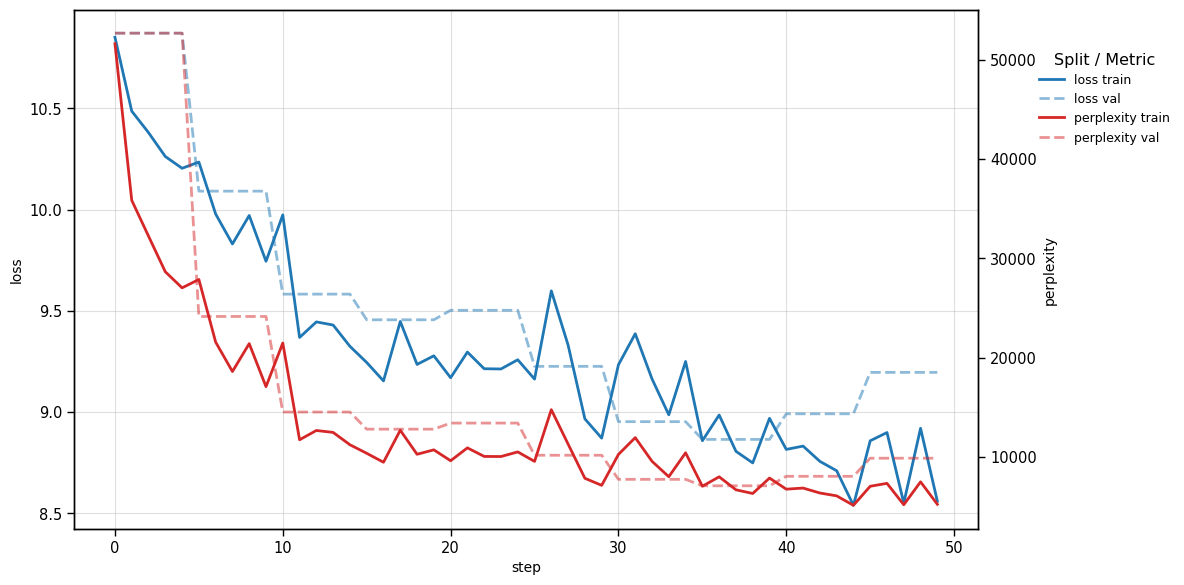

In [ ]:
import pandas as pd

losses_df = pd.DataFrame(training_metrics)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

LOSS_STYLES = {
    "train": dict(color="#1f77b4", linestyle="-"),
    "validation": dict(color="#1f77b4", linestyle="--", alpha=0.5),
}
PPLX_STYLES = {
    "train": dict(color="#d62728", linestyle="-"),
    "validation": dict(color="#d62728", linestyle="--", alpha=0.5),
}

def _lineplot_with_styles(ax, df, metric, styles):
    for split, style in styles.items():
        sns.lineplot(
            data=df[df["set"] == split],
            x="step",
            y=metric,
            ax=ax,
            label=f"{metric} {split}",
            legend=False,
            **style,
        )

def plot_losses(losses_df):

    import seaborn as sns
    sns.set_context(
        "paper",
        font_scale=1.2,
        rc={
            "lines.linewidth": 2.0,
            "axes.labelsize": 10,
            "axes.titlesize": 11,
        }
    )

    fig, ax = plt.subplots(figsize=(12, 6))
    ax1 = ax.twinx()

    _lineplot_with_styles(ax, losses_df, "loss", LOSS_STYLES)
    _lineplot_with_styles(ax1, losses_df, "perplexity", PPLX_STYLES)

    ax.grid(alpha=0.4)

    style_legend = [
        Line2D([0], [0], **LOSS_STYLES["train"], label="loss train"),
        Line2D([0], [0], **LOSS_STYLES["validation"], label="loss val"),
        Line2D([0], [0], **PPLX_STYLES["train"], label="perplexity train"),
        Line2D([0], [0], **PPLX_STYLES["validation"], label="perplexity val"),
    ]
    ax.legend(
        handles=style_legend,
        title="Split / Metric",
        loc="upper left",
        bbox_to_anchor=(1.02, 1.0),
        borderaxespad=3.0,
        fontsize=9,
        frameon=False,
    )

    plt.tight_layout()
    plt.show()

plot_losses(losses_df)